# Projet 07_ Implémenter un modèle de scoring

Client : `Prêt à dépenser` 
Domaine : Crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. 

Objectifs : 

- Mettre en place un outil de Scoring Crédit (probabilité qu'un client rembourse son crédit).
- Algorithme de classification. 
- Dashboard interactif.


Données : Les données sont Téléchargeables en suivant le lien suivant  : [Les données](https://www.kaggle.com/c/home-credit-default-risk/data)

Mission: 
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client.
- Construire un dashboard interactifà destination des gestionnaires de la relation client.
- Mettre en production le modèle de scoring de prédiction à l'aide d'une API ainsi que le dashboard. 



# Imprts


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys

#Afficher toutes le colonnes du data frame : 
pd.set_option('display.max_columns', 200)

# Mes fonction - Rapport Data Frame
# from src.mes_fonction import RapportDataFrame

# Data Ingestion : import des data et autres fonctionnalité
from src.components.data_ingestion import *
from src.utilis import *

# Les données

In [2]:
path = 'C:/Users/Lenovo/Documents/DSPython/data_projet_7'
file_name = "application_train.csv"

In [3]:
# Récupération de la base de données
data_base = DataIngestion(path, file_name = file_name, method = None)

In [4]:
# Extraction nom de fichiers avec et sans extensions
liste_name, files_liste_name = data_base.get_files_names()

In [5]:
files_liste_name

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [6]:
liste_name

['application_test',
 'application_train',
 'bureau',
 'bureau_balance',
 'credit_card_balance',
 'HomeCredit_columns_description',
 'installments_payments',
 'POS_CASH_balance',
 'previous_application',
 'sample_submission']

`application_train` et `application_test` :  le prêt et les demandeurs de prêt.

`bureau` : contient les données de demande d'autres prêts que le client a contractés auprès d'autres établissements de crédit et qui ont été signalés au bureau de crédit.

`previous_applications ` : contient des informations sur les prêts précédents chez Home Credit par le même client, les informations sur les prêts précédents et les informations sur le client au moment du prêt (il y a une ligne dans le dat frame par demande de prêt précédente).

**SK_ID_CURR** connecte les dataframes `application_train|test` avec `bureau`, `previous_application` et aussi avec les dataframes `POS_CASH_balance`, `versements_payment` et `credit_card_balance`.

**SK_ID_PREV** connecte  `previous_application` avec `POS_CASH_balance`, `versements_payment` et `credit_card_balance`.

**SK_ID_BUREAU** connecte  `bureau` avec  `bureau_balance`

In [7]:
# La liste des fichiers : ici j'ai enlevé HomeCredit_columns_description car n'arrive pas à le lire avec pd.read_csv()

files_liste_name = ['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 #'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'sample_submission.csv']

In [8]:
# Attribution des noms de dataframe respectifs : 
liste_name = ['application_test',
 'application_train',
 'bureau',
 'bureau_balance',
 'credit_card_balance',
 #'HomeCredit_columns_description',
 'installments_payments',
 'POS_CASH_balance',
 'previous_application',
 'sample_submission']

 # Importation et nommage des data sets
path = 'C:/Users/Lenovo/Documents/DSPython/data_projet_7/'
for i, name in enumerate(liste_name):
    exec(f"{name} = pd.read_csv(path + files_liste_name[i])")

## Exploration des données

In [9]:

# Liste des données à afficher : 
summary_list = []
for i, name in enumerate(liste_name):
    df = globals()[name]
    rows, cols = df.shape
    summary = {'DataFrame': name, 'Lignes': rows, 'Colonnes': cols}
    summary_list.append(summary)
summary_df = pd.DataFrame(summary_list)
summary_df

,DataFrame,Lignes,Colonnes
0,application_test,48744,121
1,application_train,307511,122
2,bureau,1716428,17
3,bureau_balance,27299925,3
4,credit_card_balance,3840312,23
5,installments_payments,13605401,8
6,POS_CASH_balance,10001358,8
7,previous_application,1670214,37
8,sample_submission,48744,2


### Rapports data frames

In [26]:
rapport_df_train = RapportDataFrame(application_train)
# Rapport : application_train
print("Data Frame : application_train")
print(20 * "--")
rapport_df_train.rapport()

Data Frame : application_train
----------------------------------------
Le Taux de remplissage total est égal à : 75.60405809287056 %
Le Nombre de features vides est égal à : 0 Features
Les Features vides sont : []

*****Nombre de catégorie features catégorielles******

NAME_CONTRACT_TYPE-------------------------------- 2
CODE_GENDER--------------------------------------- 3
FLAG_OWN_CAR-------------------------------------- 2
FLAG_OWN_REALTY----------------------------------- 2
NAME_TYPE_SUITE----------------------------------- 8
NAME_INCOME_TYPE---------------------------------- 8
NAME_EDUCATION_TYPE------------------------------- 5
NAME_FAMILY_STATUS-------------------------------- 6
NAME_HOUSING_TYPE--------------------------------- 6
OCCUPATION_TYPE----------------------------------- 19
WEEKDAY_APPR_PROCESS_START------------------------ 7
ORGANIZATION_TYPE--------------------------------- 58
FONDKAPREMONT_MODE-------------------------------- 5
HOUSETYPE_MODE------------------------

In [43]:
application_train_df_missing_value = rapport_df_train.chek_missing()
application_train_df_missing_value

,Total_NAN,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
...,...,...
NAME_HOUSING_TYPE,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_EDUCATION_TYPE,0,0.000000
NAME_INCOME_TYPE,0,0.000000


In [55]:
# Pour récupérer les noms de colonnes d'un data frame : Exemple pour previous_application
original_columns_train, categorical_columns_train, numerical_columns_train, binary_columns_train= rapport_df_train.get_df_columns()

In [56]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [27]:
rapport_df_test = RapportDataFrame(application_test)
# Rapport : application_test
print("Data Frame : application_test")
print(20 * "--")
rapport_df_test.rapport()

Data Frame : application_test
----------------------------------------
Le Taux de remplissage total est égal à : 76.18831323846766 %
Le Nombre de features vides est égal à : 0 Features
Les Features vides sont : []

*****Nombre de catégorie features catégorielles******

NAME_CONTRACT_TYPE-------------------------------- 2
CODE_GENDER--------------------------------------- 2
FLAG_OWN_CAR-------------------------------------- 2
FLAG_OWN_REALTY----------------------------------- 2
NAME_TYPE_SUITE----------------------------------- 8
NAME_INCOME_TYPE---------------------------------- 7
NAME_EDUCATION_TYPE------------------------------- 5
NAME_FAMILY_STATUS-------------------------------- 5
NAME_HOUSING_TYPE--------------------------------- 6
OCCUPATION_TYPE----------------------------------- 19
WEEKDAY_APPR_PROCESS_START------------------------ 7
ORGANIZATION_TYPE--------------------------------- 58
FONDKAPREMONT_MODE-------------------------------- 5
HOUSETYPE_MODE-------------------------

In [42]:
application_test_df_missing_value = rapport_df_test.chek_missing()
application_test_df_missing_value

,Total_NAN,Percent
COMMONAREA_AVG,33495,68.716150
COMMONAREA_MODE,33495,68.716150
COMMONAREA_MEDI,33495,68.716150
NONLIVINGAPARTMENTS_AVG,33347,68.412523
NONLIVINGAPARTMENTS_MODE,33347,68.412523
...,...,...
NAME_HOUSING_TYPE,0,0.000000
NAME_FAMILY_STATUS,0,0.000000
NAME_EDUCATION_TYPE,0,0.000000
NAME_INCOME_TYPE,0,0.000000


In [28]:
rapport_df_bureau = RapportDataFrame(bureau)
# Rapport : bureau
print("Data Frame : bureau")
print(20 * "--")
rapport_df_bureau.rapport()

Data Frame : bureau
----------------------------------------
Le Taux de remplissage total est égal à : 86.49744770912068 %
Le Nombre de features vides est égal à : 0 Features
Les Features vides sont : []

*****Nombre de catégorie features catégorielles******

CREDIT_ACTIVE------------------------------------- 4
CREDIT_CURRENCY----------------------------------- 4
CREDIT_TYPE--------------------------------------- 15


In [41]:
bureau_df_missing_value = rapport_df_bureau.chek_missing()
bureau_df_missing_value

,Total_NAN,Percent
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_ACTIVE,0,0.000000
CREDIT_CURRENCY,0,0.000000
DAYS_CREDIT,0,0.000000


In [29]:
rapport_df_bureau_balance = RapportDataFrame(bureau_balance)
# Rapport : bureau_balance
print("Data Frame : bureau_balance")
print(20 * "--")
rapport_df_bureau_balance.rapport()

Data Frame : bureau_balance
----------------------------------------
Le Taux de remplissage total est égal à : 100.0 %
Le Nombre de features vides est égal à : 0 Features
Les Features vides sont : []

*****Nombre de catégorie features catégorielles******

STATUS-------------------------------------------- 8


In [30]:
rapport_df_bureau_credit_card_balance = RapportDataFrame(credit_card_balance)
# Rapport : credit_card_balance
print("Data Frame : credit_card_balance")
print(20 * "--")
rapport_df_bureau_credit_card_balance.rapport()

Data Frame : credit_card_balance
----------------------------------------
Le Taux de remplissage total est égal à : 93.34592560731252 %
Le Nombre de features vides est égal à : 0 Features
Les Features vides sont : []

*****Nombre de catégorie features catégorielles******

NAME_CONTRACT_STATUS------------------------------ 7


In [40]:
credit_card_balance_df_missing_value = rapport_df_bureau_credit_card_balance.chek_missing()
credit_card_balance_df_missing_value

,Total_NAN,Percent
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_ID_PREV,0,0.000000


In [31]:
rapport_df_installments_payments = RapportDataFrame(installments_payments)
# Rapport : installments_payments
print("Data Frame : installments_payments")
print(20 * "--")
rapport_df_installments_payments.rapport()

Data Frame : installments_payments
----------------------------------------
Le Taux de remplissage total est égal à : 99.99466204634469 %
Le Nombre de features vides est égal à : 0 Features
Les Features vides sont : []

*****Nombre de catégorie features catégorielles******



In [39]:
installments_payments_df_missing_value = rapport_df_installments_payments.chek_missing()
installments_payments_df_missing_value

,Total_NAN,Percent
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_PAYMENT,2905,0.021352
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000
NUM_INSTALMENT_NUMBER,0,0.000000
DAYS_INSTALMENT,0,0.000000
AMT_INSTALMENT,0,0.000000


In [32]:
rapport_df_POS_CASH_balance = RapportDataFrame(POS_CASH_balance)
# Rapport : POS_CASH_balance
print("Data Frame : POS_CASH_balance")
print(20 * "--")
rapport_df_POS_CASH_balance.rapport()

Data Frame : POS_CASH_balance
----------------------------------------
Le Taux de remplissage total est égal à : 99.93481135261831 %
Le Nombre de features vides est égal à : 0 Features
Les Features vides sont : []

*****Nombre de catégorie features catégorielles******

NAME_CONTRACT_STATUS------------------------------ 9


In [38]:
POS_CASH_balance_df_missing_value = rapport_df_POS_CASH_balance.chek_missing()
POS_CASH_balance_df_missing_value

,Total_NAN,Percent
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_ID_PREV,0,0.000000
SK_ID_CURR,0,0.000000
MONTHS_BALANCE,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
SK_DPD,0,0.000000
SK_DPD_DEF,0,0.000000


In [33]:
rapport_df_previous_application = RapportDataFrame(previous_application)
# Rapport : previous_application
print("Data Frame : previous_application")
print(20 * "--")
rapport_df_previous_application.rapport()



Data Frame : previous_application
----------------------------------------
Le Taux de remplissage total est égal à : 82.02312252655503 %
Le Nombre de features vides est égal à : 0 Features
Les Features vides sont : []

*****Nombre de catégorie features catégorielles******

NAME_CONTRACT_TYPE-------------------------------- 4
WEEKDAY_APPR_PROCESS_START------------------------ 7
FLAG_LAST_APPL_PER_CONTRACT----------------------- 2
NAME_CASH_LOAN_PURPOSE---------------------------- 25
NAME_CONTRACT_STATUS------------------------------ 4
NAME_PAYMENT_TYPE--------------------------------- 4
CODE_REJECT_REASON-------------------------------- 9
NAME_TYPE_SUITE----------------------------------- 8
NAME_CLIENT_TYPE---------------------------------- 4
NAME_GOODS_CATEGORY------------------------------- 28
NAME_PORTFOLIO------------------------------------ 5
NAME_PRODUCT_TYPE--------------------------------- 3
CHANNEL_TYPE-------------------------------------- 8
NAME_SELLER_INDUSTRY---------------

In [37]:
previous_application_df_missing_value = rapport_df_previous_application.chek_missing()
previous_application_df_missing_value

,Total_NAN,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_TERMINATION,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129


,Total_NAN,Percent
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
AMT_DOWN_PAYMENT,895844,53.636480
RATE_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_TERMINATION,673065,40.298129
DAYS_LAST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129


In [34]:
rapport_df_sample_submission = RapportDataFrame(sample_submission)
# Rapport : sample_submission
print("Data Frame : sample_submission")
print(20 * "--")
rapport_df_sample_submission.rapport()

Data Frame : sample_submission
----------------------------------------
Le Taux de remplissage total est égal à : 100.0 %
Le Nombre de features vides est égal à : 0 Features
Les Features vides sont : []

*****Nombre de catégorie features catégorielles******



In [19]:
# Pour récupérer les noms de colonnes d'un data frame : Exemple pour previous_application
original_columns, categorical_columns, numerical_columns, binary_columns= rapport_df_previous_application.get_df_columns()

In [20]:
original_columns

['SK_ID_PREV',
 'SK_ID_CURR',
 'NAME_CONTRACT_TYPE',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'DAYS_DECISION',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'SELLERPLACE_AREA',
 'NAME_SELLER_INDUSTRY',
 'CNT_PAYMENT',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

In [21]:
categorical_columns

['NAME_CONTRACT_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'FLAG_LAST_APPL_PER_CONTRACT',
 'NAME_CASH_LOAN_PURPOSE',
 'NAME_CONTRACT_STATUS',
 'NAME_PAYMENT_TYPE',
 'CODE_REJECT_REASON',
 'NAME_TYPE_SUITE',
 'NAME_CLIENT_TYPE',
 'NAME_GOODS_CATEGORY',
 'NAME_PORTFOLIO',
 'NAME_PRODUCT_TYPE',
 'CHANNEL_TYPE',
 'NAME_SELLER_INDUSTRY',
 'NAME_YIELD_GROUP',
 'PRODUCT_COMBINATION']

In [22]:
numerical_columns

['SK_ID_PREV',
 'SK_ID_CURR',
 'AMT_ANNUITY',
 'AMT_APPLICATION',
 'AMT_CREDIT',
 'AMT_DOWN_PAYMENT',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'NFLAG_LAST_APPL_IN_DAY',
 'RATE_DOWN_PAYMENT',
 'RATE_INTEREST_PRIMARY',
 'RATE_INTEREST_PRIVILEGED',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL']

In [23]:
binary_columns

['FLAG_LAST_APPL_PER_CONTRACT']

# Exploration graphique

### La target

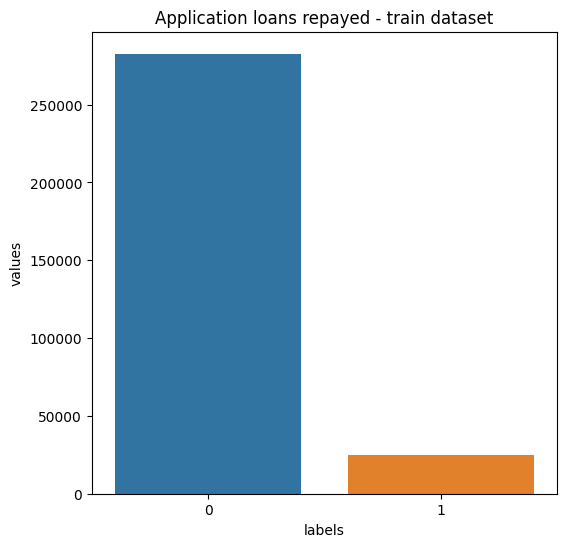

In [44]:
temp = application_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Application loans repayed - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

In [45]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = application_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = application_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show()

In [46]:
def plot_distribution(var):
    
    i = 0
    t1 = application_train.loc[application_train['TARGET'] != 0]
    t0 = application_train.loc[application_train['TARGET'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,2,figsize=(12,12))

    for feature in var:
        i += 1
        plt.subplot(2,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

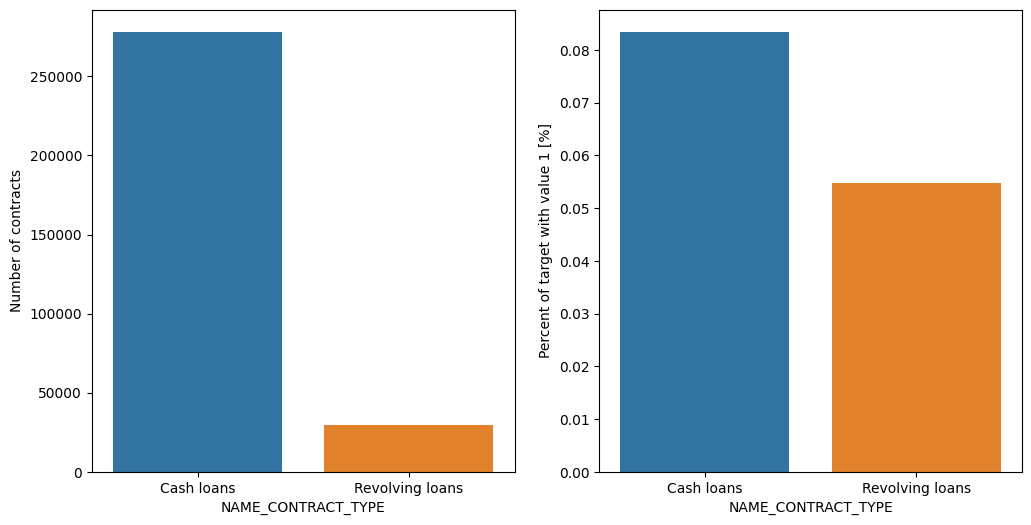

In [50]:
plot_stats('NAME_CONTRACT_TYPE', label_rotation=False,horizontal_layout=True)

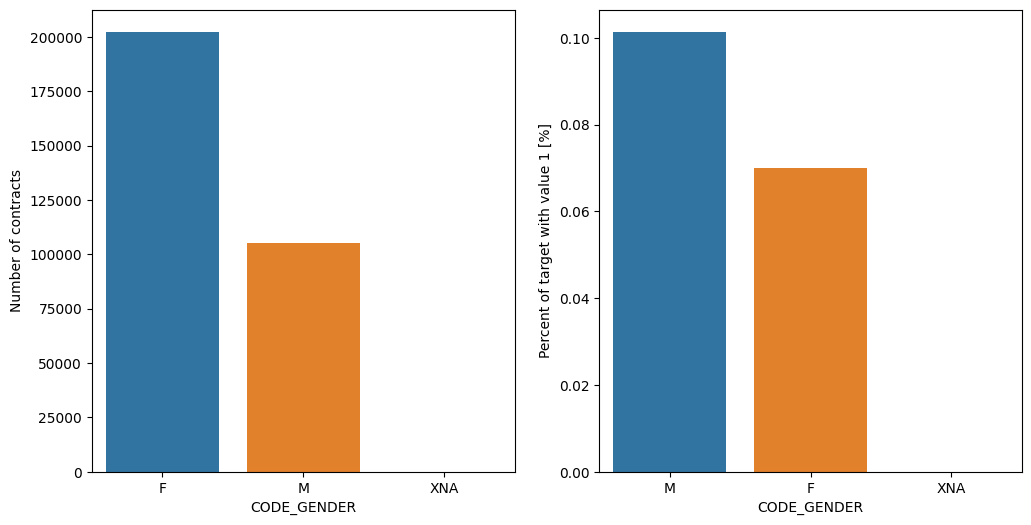

In [48]:
plot_stats('CODE_GENDER')

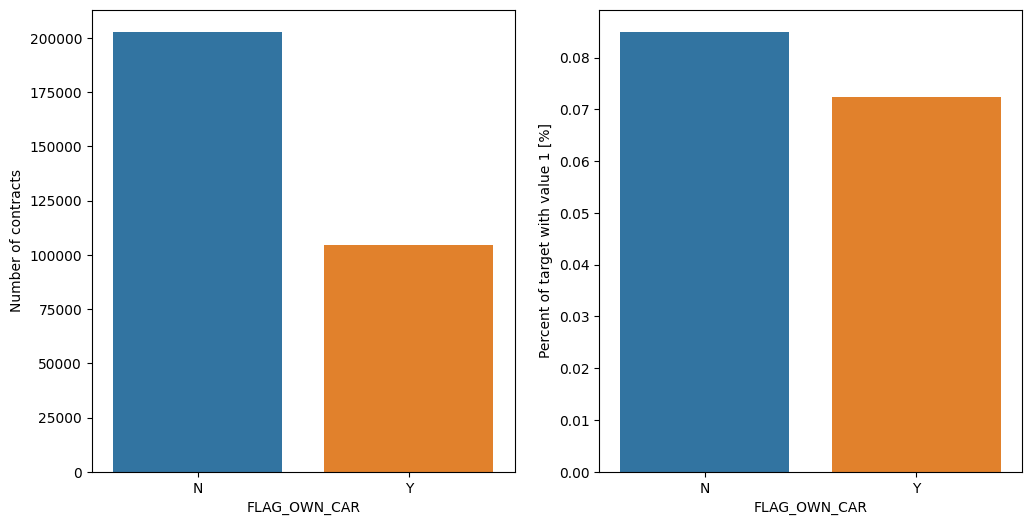

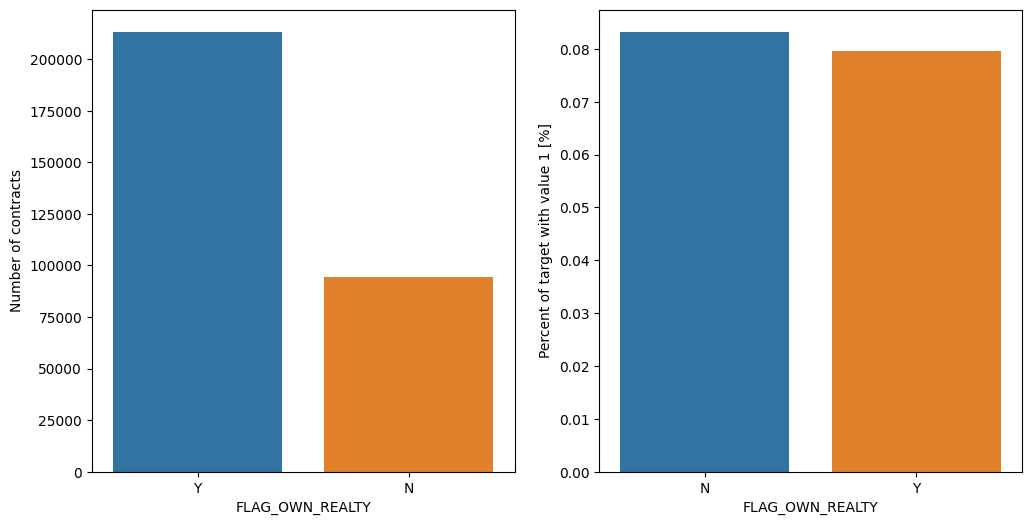

In [51]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

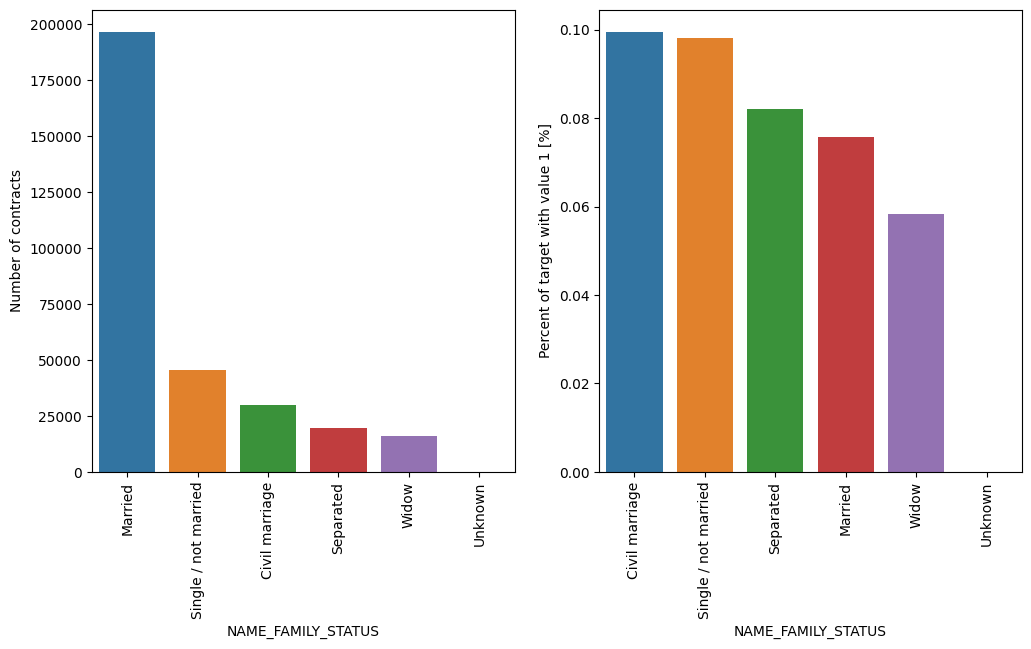

In [52]:
plot_stats('NAME_FAMILY_STATUS',True, True)

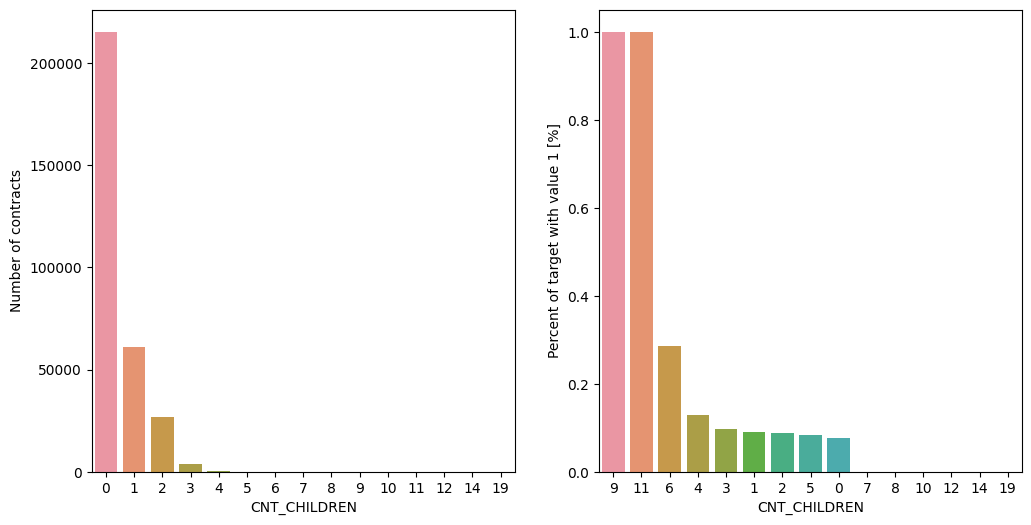

In [53]:
plot_stats('CNT_CHILDREN')

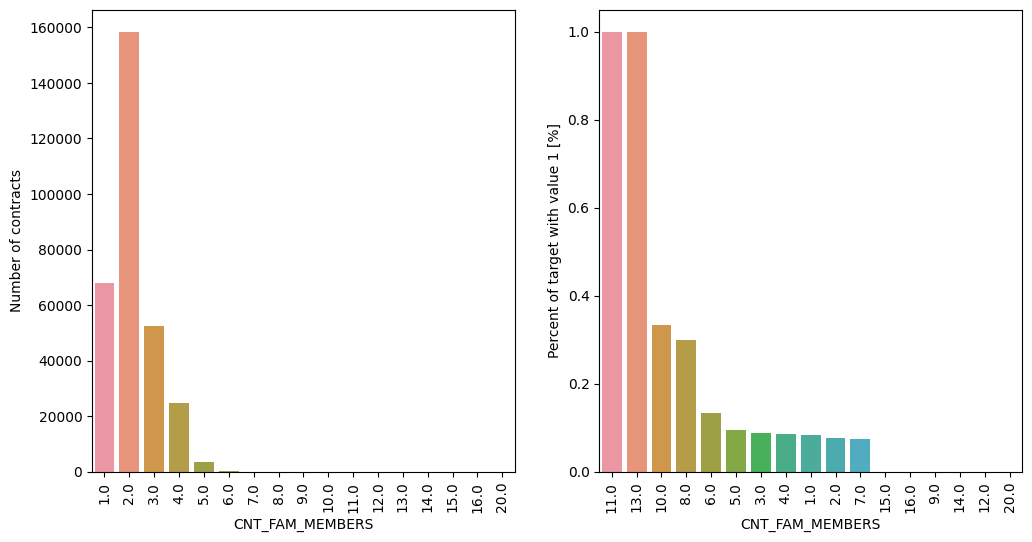

In [54]:
plot_stats('CNT_FAM_MEMBERS',True)